In [1]:
!pip install scikit-learn==1.3.2 imbalanced-learn==0.13.0

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

RANDOM_STATE = 42
DATA_PATH = "/content/Diabetes Risk Survey (Responses) (1).xlsx"
TARGET_COL = "Have you ever been diagnosed with diabetes?"

In [2]:
df = pd.read_excel(DATA_PATH)

print("shape:", df.shape)
df.head()


shape: (271, 22)


,Timestamp,Age,Gender,Hight(cm),Weight(kg),Do you have a family history of diabetes?,How often do you exercise per week?,How would you describe your diet?,Have you ever been diagnosed with diabetes?,Have you ever been diagnosed with high blood pressure or cholesterol?,...,Do you often feel unusually thirsty?,Have you noticed unexplained weight loss or gain?,Do you feel unusually fatigued or tired?,Do you have blurred vision or slow-healing wounds?,Occupation,Average sleep hours per night,Waist circumference (cm),Systolic BP (mmHg),Diastolic BP (mmHg),BMI (kg/m²)
0,2025-11-10 16:45:47.414,20 - 29,Male,150 - 159 cm,60 - 69 kg,Yes,3 - 6 times,Mixed,No,No,...,No,No,Yes,No,Student,7-8 hours,32,120.0,80,25.3
1,2025-11-11 08:09:42.946,60 and above,Female,150 - 159 cm,70 - 79 kg,Yes,Never,Mixed,Yes,Yes,...,Yes,Yes,Yes,Yes,Unemployed,0-5 hours,34,140.0,80,33.3
2,2025-11-11 08:19:09.357,50 - 59,Female,150 - 159 cm,50 - 59 kg,Yes,1 - 3 times,Mixed,Yes,Yes,...,No,No,No,Yes,Unemployed,0-5 hours,30,120.0,80,24.4
3,2025-11-11 08:24:42.515,60 and above,Female,Below 150 cm,60 - 69 kg,Yes,Never,Mixed,Yes,Yes,...,No,Yes,Yes,Yes,Unemployed,7-8 hours,34,164.0,83,27.0
4,2025-11-11 08:30:00.727,50 - 59,Female,150 - 159 cm,50 - 59 kg,Yes,Never,Mostly healthy,No,Yes,...,Yes,Yes,Yes,Yes,Unemployed,0-5 hours,28,130.0,83,28.1


In [3]:
# remove timestamp if it's there
if "Timestamp" in df.columns:
    df = df.drop(columns=["Timestamp"])

# make column names cleaner
df.columns = [c.strip() for c in df.columns]

# convert target Yes/No to 1/0
df[TARGET_COL] = df[TARGET_COL].astype(str).str.strip().map({"No": 0, "Yes": 1})

# remove rows where target is missing
df = df.dropna(subset=[TARGET_COL])

print(df[TARGET_COL].value_counts())


Have you ever been diagnosed with diabetes?
1    177
0     94
Name: count, dtype: int64


In [4]:
if "Waist circumference (cm)" in df.columns:
    df["Waist circumference (cm)"] = pd.to_numeric(df["Waist circumference (cm)"], errors="coerce")

df.describe(include="all").T.head(12)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,271,5,60 and above,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,271,2,Male,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hight(cm),271,5,160 - 169 cm,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weight(kg),271,5,60 - 69 kg,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Do you have a family history of diabetes?,271,2,Yes,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
How often do you exercise per week?,271,4,Never,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN
How would you describe your diet?,271,3,Mixed,264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Have you ever been diagnosed with diabetes?,271.0,NaN,NaN,NaN,0.653137,0.476852,0.0,0.0,1.0,1.0,1.0
Have you ever been diagnosed with high blood pressure or cholesterol?,271,2,No,146,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Are you currently taking any medications for diabetes or related conditions?,271,2,Yes,176,NaN,NaN,NaN,NaN,NaN,NaN,NaN


No diabetes (0): 94
Diabetes (1): 177
imbalance ratio: 1.883


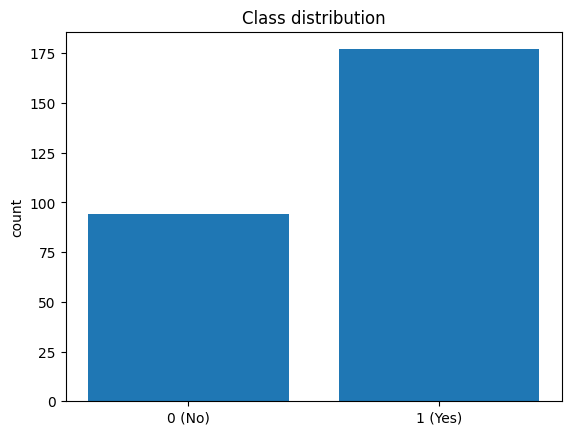

In [5]:
counts = df[TARGET_COL].value_counts().sort_index()
ratio = counts.max() / counts.min()

print("No diabetes (0):", counts.get(0, 0))
print("Diabetes (1):", counts.get(1, 0))
print("imbalance ratio:", round(float(ratio), 3))

plt.figure()
plt.bar(["0 (No)", "1 (Yes)"], [counts.get(0,0), counts.get(1,0)])
plt.title("Class distribution")
plt.ylabel("count")
plt.show()


In [6]:
leakage_cols = [
    "Are you currently taking any medications for diabetes or related conditions?"
]

# optional: remove late symptoms if your accuracy becomes unrealistic
late_symptom_cols = [
    "Do you have blurred vision or slow-healing wounds?",
    "Do you experience frequent urination?",
    "Do you often feel unusually thirsty?",
    "Do you feel unusually fatigued or tired?"
]

drop_cols = [c for c in (leakage_cols + late_symptom_cols) if c in df.columns]
print("dropping:", drop_cols)

df2 = df.drop(columns=drop_cols)


dropping: ['Are you currently taking any medications for diabetes or related conditions?', 'Do you have blurred vision or slow-healing wounds?', 'Do you experience frequent urination?', 'Do you often feel unusually thirsty?', 'Do you feel unusually fatigued or tired?']


Waist circumference (cm)                                                 1
Age                                                                      0
Gender                                                                   0
Hight(cm)                                                                0
Weight(kg)                                                               0
Do you have a family history of diabetes?                                0
How often do you exercise per week?                                      0
How would you describe your diet?                                        0
Have you ever been diagnosed with diabetes?                              0
Have you ever been diagnosed with high blood pressure or cholesterol?    0
dtype: int64


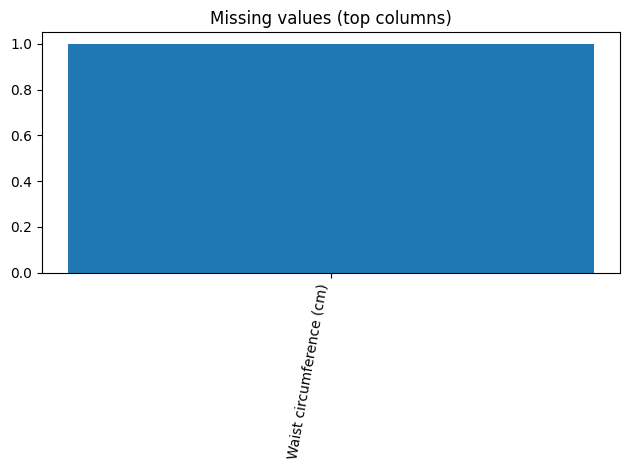

In [7]:
missing = df2.isna().sum().sort_values(ascending=False)
print(missing.head(10))

top_missing = missing[missing > 0].head(15)

plt.figure()
plt.bar(top_missing.index.astype(str), top_missing.values)
plt.title("Missing values (top columns)")
plt.xticks(rotation=80, ha="right")
plt.tight_layout()
plt.show()


In [8]:
X = df2.drop(columns=[TARGET_COL])
y = df2[TARGET_COL].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

print("train:", X_train.shape, "test:", X_test.shape)


train: (203, 15) test: (68, 15)


In [9]:
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

print("numeric cols:", num_cols)
print("categorical cols:", len(cat_cols))

num_pipe = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ],
    remainder="drop"
)


numeric cols: ['Waist circumference (cm)', 'Systolic BP (mmHg)', 'Diastolic BP (mmHg)', 'BMI (kg/m²)']
categorical cols: 11


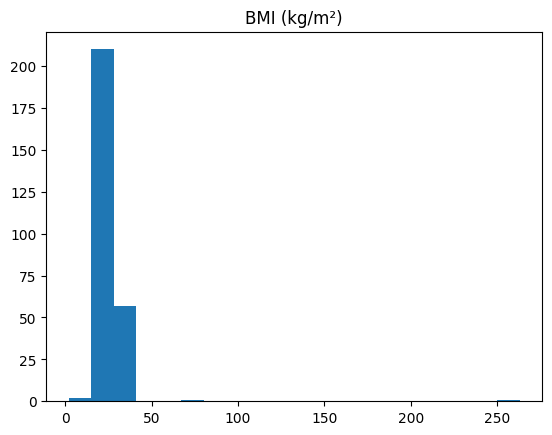

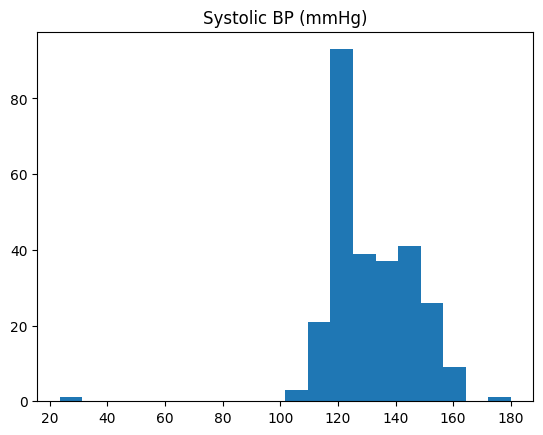

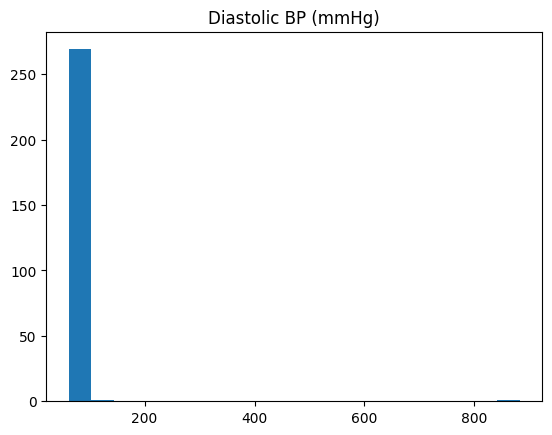

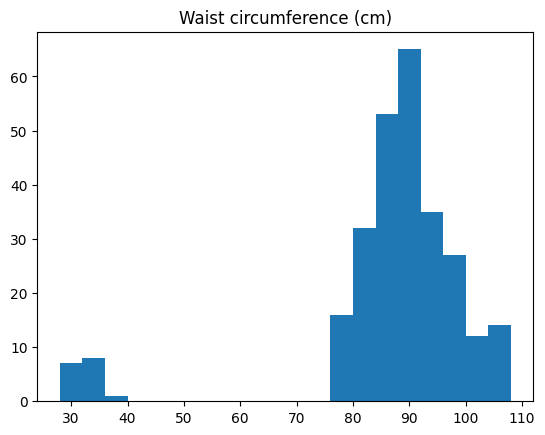

In [10]:
for col in ["BMI (kg/m²)", "Systolic BP (mmHg)", "Diastolic BP (mmHg)", "Waist circumference (cm)"]:
    if col in X_train.columns:
        plt.figure()
        plt.hist(df2[col].dropna(), bins=20)
        plt.title(col)
        plt.show()


In [11]:
smote = SMOTE(sampling_strategy=0.9, k_neighbors=3, random_state=RANDOM_STATE)

def make_pipe(model):
    return ImbPipeline(steps=[
        ("prep", preprocess),
        ("smote", smote),
        ("model", model)
    ])


In [12]:
models = {
    "logreg": LogisticRegression(max_iter=3000, class_weight="balanced", random_state=RANDOM_STATE),
    "svm": SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=RANDOM_STATE),
    "rf": RandomForestClassifier(n_estimators=400, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=1),
    "extratrees": ExtraTreesClassifier(n_estimators=600, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=1),
    "histgb": HistGradientBoostingClassifier(random_state=RANDOM_STATE)
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)
scoring = {"roc_auc": "roc_auc", "acc": "accuracy", "f1": "f1", "recall": "recall"}

rows = []
for name, m in models.items():
    pipe = make_pipe(m)
    scores = cross_validate(pipe, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)
    rows.append({
        "model": name,
        "auc": scores["test_roc_auc"].mean(),
        "acc": scores["test_acc"].mean(),
        "recall": scores["test_recall"].mean(),
        "f1": scores["test_f1"].mean()
    })

cv_results = pd.DataFrame(rows).sort_values("auc", ascending=False)
cv_results


,model,auc,acc,recall,f1
1,svm,0.908710,0.856992,0.899240,0.890859
0,logreg,0.907055,0.843780,0.846439,0.875039
2,rf,0.895601,0.857073,0.919468,0.893302
4,histgb,0.887190,0.837236,0.891833,0.876567
3,extratrees,0.885992,0.852073,0.901994,0.888098


In [13]:
top2 = cv_results["model"].head(2).tolist()
top2


['svm', 'logreg']

In [14]:
param_spaces = {
    "extratrees": {
        "model__n_estimators": [200, 400, 600, 800, 1000],
        "model__max_depth": [None, 4, 6, 8, 10, 14],
        "model__min_samples_split": [2, 5, 10, 15, 20],
        "model__min_samples_leaf": [1, 2, 4, 6, 8],
        "model__max_features": ["sqrt", "log2", None],
    },
    "rf": {
        "model__n_estimators": [200, 400, 600, 800, 1000],
        "model__max_depth": [None, 4, 6, 8, 10, 14],
        "model__min_samples_split": [2, 5, 10, 15, 20],
        "model__min_samples_leaf": [1, 2, 4, 6, 8],
        "model__max_features": ["sqrt", "log2", None],
    },
    "svm": {
        "model__C": np.linspace(0.5, 10, 20).tolist(),
        "model__gamma": ["scale", "auto"]
    },
    "logreg": {
        "model__C": np.linspace(0.1, 5, 30).tolist()
    },
    "histgb": {
        "model__learning_rate": np.linspace(0.01, 0.2, 20).tolist(),
        "model__max_depth": [None, 3, 5, 7, 9],
        "model__min_samples_leaf": [10, 20, 30, 40]
    }
}

best_search = None
best_score = -1

for name in top2:
    pipe = make_pipe(models[name])

    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_spaces[name],
        n_iter=25,
        scoring="roc_auc",
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        random_state=RANDOM_STATE,
        n_jobs=1
    )
    search.fit(X_train, y_train)

    print("\n", name, "best auc:", round(search.best_score_, 4))
    print("best params:", search.best_params_)

    if search.best_score_ > best_score:
        best_score = search.best_score_
        best_search = search

best_pipe = best_search.best_estimator_
print("\nfinal chosen model:", best_pipe.named_steps["model"])



 svm best auc: 0.9097
best params: {'model__gamma': 'auto', 'model__C': 10.0}

 logreg best auc: 0.9182
best params: {'model__C': 0.1}

final chosen model: LogisticRegression(C=0.1, class_weight='balanced', max_iter=3000,
                   random_state=42)


In [15]:
best_pipe.fit(X_train, y_train)

proba = best_pipe.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("ROC-AUC:", round(roc_auc_score(y_test, proba), 4))
print("Accuracy:", round(accuracy_score(y_test, pred), 4))
print("Precision:", round(precision_score(y_test, pred, zero_division=0), 4))
print("Recall:", round(recall_score(y_test, pred, zero_division=0), 4))
print("F1:", round(f1_score(y_test, pred, zero_division=0), 4))


ROC-AUC: 0.9233
Accuracy: 0.8382
Precision: 0.9231
Recall: 0.8182
F1: 0.8675


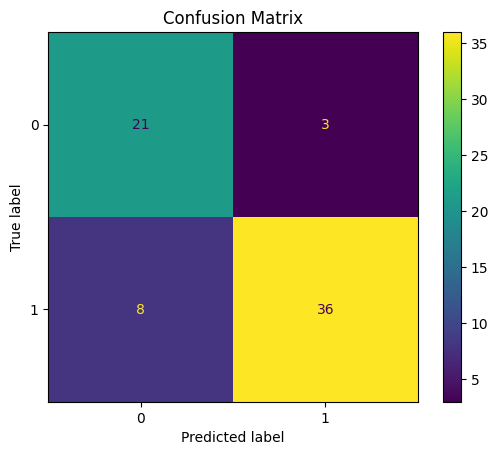

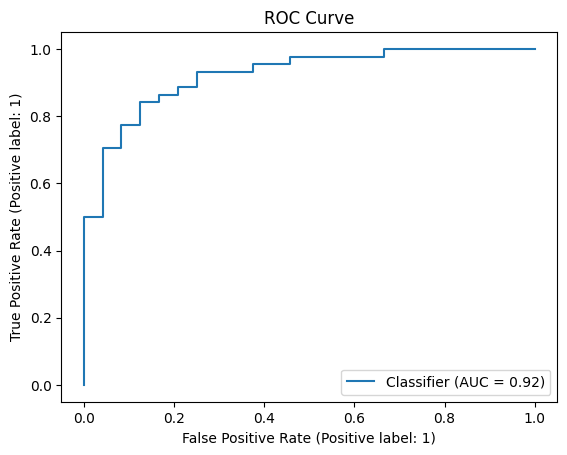

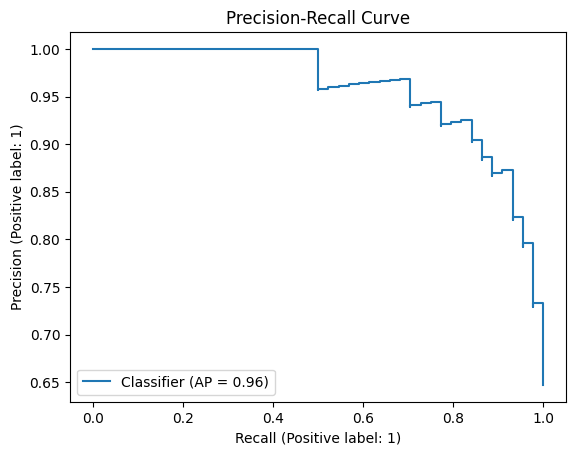

In [16]:
ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.title("Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC Curve")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, proba)
plt.title("Precision-Recall Curve")
plt.show()


best threshold: 0.4 train f1: 0.9265
test acc: 0.8529
test recall: 0.8864
test f1: 0.8864


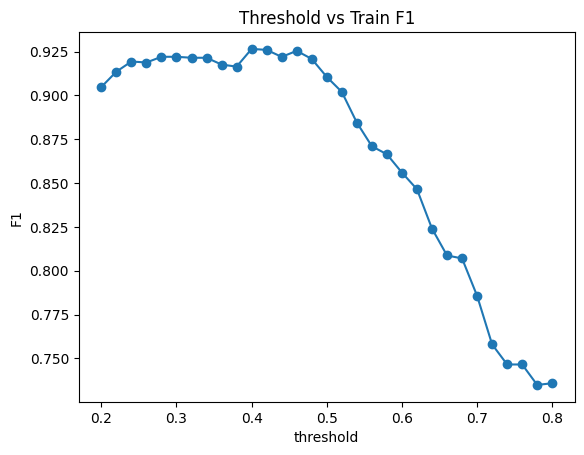

In [17]:
ths = np.linspace(0.2, 0.8, 31)

train_proba = best_pipe.predict_proba(X_train)[:, 1]

best_t = 0.5
best_f1 = -1

for t in ths:
    train_pred_t = (train_proba >= t).astype(int)
    f1 = f1_score(y_train, train_pred_t, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("best threshold:", round(best_t, 3), "train f1:", round(best_f1, 4))

pred_t = (proba >= best_t).astype(int)
print("test acc:", round(accuracy_score(y_test, pred_t), 4))
print("test recall:", round(recall_score(y_test, pred_t, zero_division=0), 4))
print("test f1:", round(f1_score(y_test, pred_t, zero_division=0), 4))

plt.figure()
plt.plot(ths, [f1_score(y_train, (train_proba >= t).astype(int), zero_division=0) for t in ths], marker="o")
plt.title("Threshold vs Train F1")
plt.xlabel("threshold")
plt.ylabel("F1")
plt.show()


In [18]:
print("Permutation importance (this can take a bit)")

perm = permutation_importance(
    best_pipe, X_test, y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="roc_auc"
)

feat_names = X_test.columns
imp = pd.DataFrame({
    "feature": feat_names,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False).head(15)

imp

Permutation importance (this can take a bit)


,feature,importance
0,Age,0.062311
12,Systolic BP (mmHg),0.039489
7,Have you ever been diagnosed with high blood p...,0.018561
4,Do you have a family history of diabetes?,0.017235
11,Waist circumference (cm),0.008807
14,BMI (kg/m²),0.007860
5,How often do you exercise per week?,0.000189
6,How would you describe your diet?,0.000095
10,Average sleep hours per night,-0.000379
13,Diastolic BP (mmHg),-0.001042


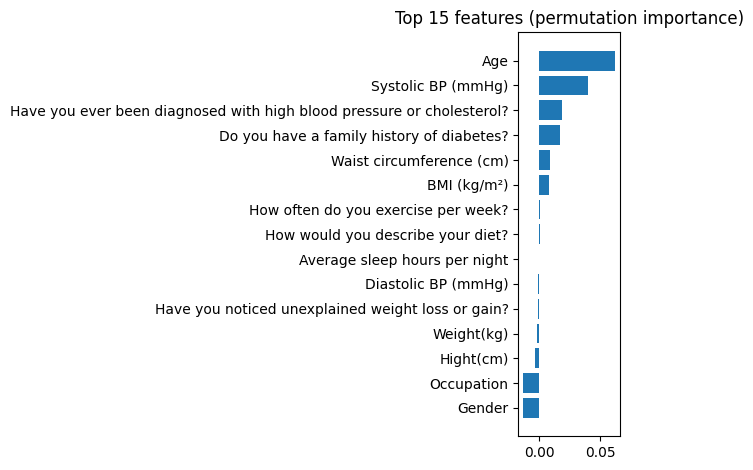

In [19]:
plt.figure()
plt.barh(imp["feature"][::-1], imp["importance"][::-1])
plt.title("Top 15 features (permutation importance)")
plt.tight_layout()
plt.show()


In [20]:
import os
from datetime import datetime
import matplotlib.pyplot as plt

# make a folder to save plots (new folder each run)
output_dir = "fyp_plots_" + datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs(output_dir, exist_ok=True)
print("Saving plots to:", output_dir)

def save_plot(name):
    path = os.path.join(output_dir, name)
    plt.tight_layout()
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print("saved:", path)


Saving plots to: fyp_plots_20260204_220702


saved: fyp_plots_20260204_220702/Plot16_Calibration_Curve.png


<Figure size 640x480 with 0 Axes>

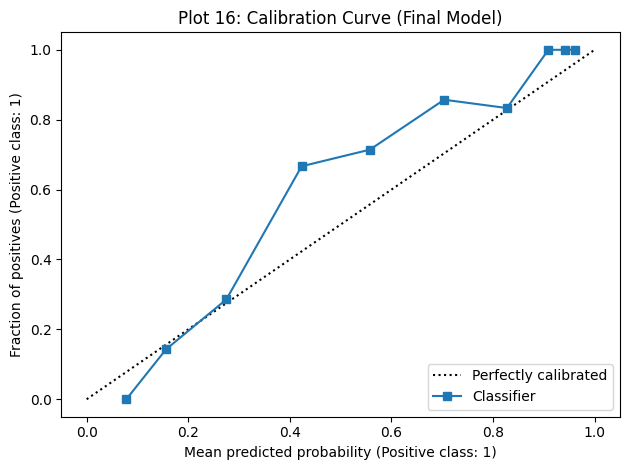

Brier score (lower is better): 0.1113


In [21]:
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss

plt.figure()
CalibrationDisplay.from_predictions(
    y_test, proba,
    n_bins=10,
    strategy="quantile"
)
plt.title("Plot 16: Calibration Curve (Final Model)")
save_plot("Plot16_Calibration_Curve.png")
plt.show()

brier = brier_score_loss(y_test, proba)
print("Brier score (lower is better):", round(brier, 4))

saved: fyp_plots_20260204_220702/Plot17_Probability_Distribution.png


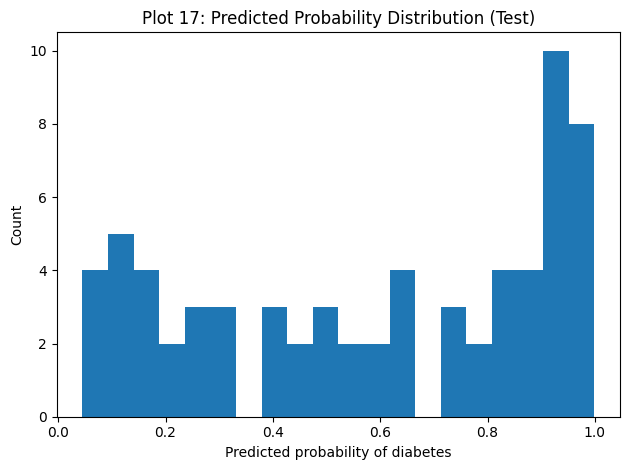

In [22]:
plt.figure()
plt.hist(proba, bins=20)
plt.title("Plot 17: Predicted Probability Distribution (Test)")
plt.xlabel("Predicted probability of diabetes")
plt.ylabel("Count")
save_plot("Plot17_Probability_Distribution.png")
plt.show()

saved: fyp_plots_20260204_220702/Plot18_Learning_Curve_ROCAUC.png


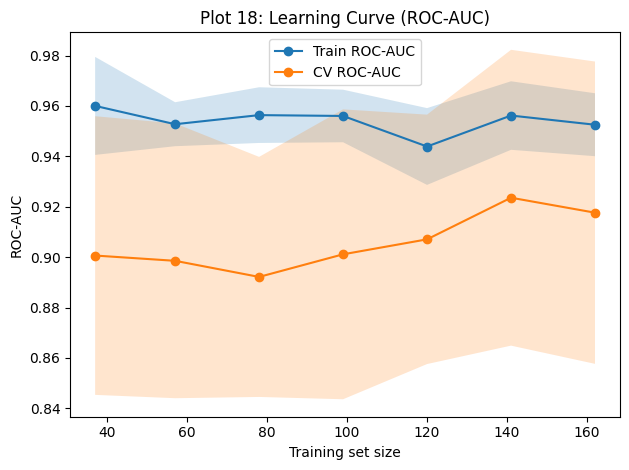

Learning curve summary:
train size=16 | train AUC=nan | cv AUC=nan
train size=37 | train AUC=0.9600 | cv AUC=0.9006
train size=57 | train AUC=0.9528 | cv AUC=0.8985
train size=78 | train AUC=0.9564 | cv AUC=0.8921
train size=99 | train AUC=0.9560 | cv AUC=0.9011
train size=120 | train AUC=0.9439 | cv AUC=0.9071
train size=141 | train AUC=0.9562 | cv AUC=0.9236
train size=162 | train AUC=0.9526 | cv AUC=0.9176


In [23]:
from sklearn.model_selection import learning_curve, StratifiedKFold

train_sizes, train_scores, val_scores = learning_curve(
    best_pipe,
    X_train,
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="roc_auc",
    n_jobs=1
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, marker="o", label="Train ROC-AUC")
plt.plot(train_sizes, val_mean, marker="o", label="CV ROC-AUC")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title("Plot 18: Learning Curve (ROC-AUC)")
plt.xlabel("Training set size")
plt.ylabel("ROC-AUC")
plt.legend()
save_plot("Plot18_Learning_Curve_ROCAUC.png")
plt.show()

print("Learning curve summary:")
for n, tr, cv in zip(train_sizes, train_mean, val_mean):
    print(f"train size={int(n)} | train AUC={tr:.4f} | cv AUC={cv:.4f}")


saved: fyp_plots_20260204_220702/Plot01_Class_Distribution.png


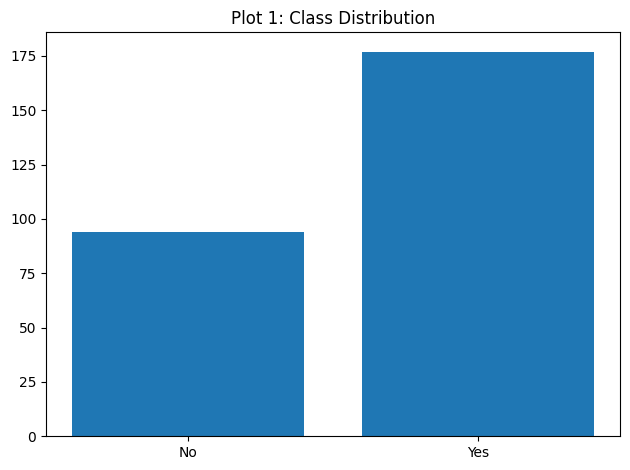

In [24]:
# example plot (you can do the same for Plot 1..15)
plt.figure()
plt.bar(["No", "Yes"], [94, 177])
plt.title("Plot 1: Class Distribution")
save_plot("Plot01_Class_Distribution.png")
plt.show()


saved: fyp_plots_20260204_220702/Plot19_Calibration_Isotonic.png


<Figure size 640x480 with 0 Axes>

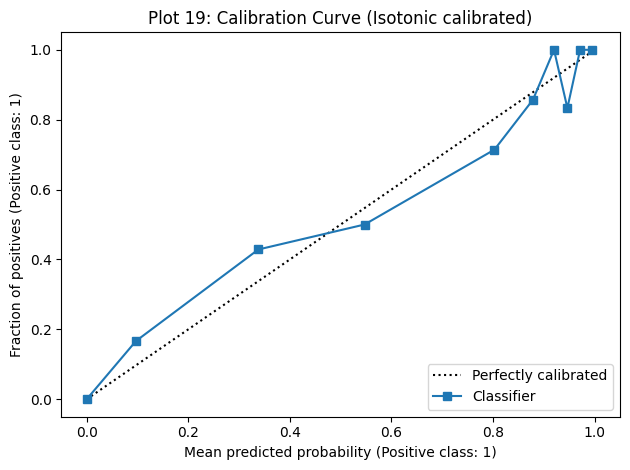

Brier (before): 0.1113
Brier (after) : 0.1146


In [25]:
from sklearn.calibration import CalibratedClassifierCV

cal_model = CalibratedClassifierCV(best_pipe, method="isotonic", cv=5)
cal_model.fit(X_train, y_train)

cal_proba = cal_model.predict_proba(X_test)[:, 1]

plt.figure()
CalibrationDisplay.from_predictions(
    y_test, cal_proba,
    n_bins=10,
    strategy="quantile"
)
plt.title("Plot 19: Calibration Curve (Isotonic calibrated)")
save_plot("Plot19_Calibration_Isotonic.png")
plt.show()

print("Brier (before):", round(brier_score_loss(y_test, proba), 4))
print("Brier (after) :", round(brier_score_loss(y_test, cal_proba), 4))

In [26]:
from sklearn.metrics import accuracy_score

train_pred = best_pipe.predict(X_train)
test_pred  = best_pipe.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc  = accuracy_score(y_test, test_pred)

print("Train accuracy:", round(train_acc, 4))
print("Test accuracy :", round(test_acc, 4))


Train accuracy: 0.8867
Test accuracy : 0.8382


In [27]:
from sklearn.metrics import roc_auc_score

train_proba = best_pipe.predict_proba(X_train)[:, 1]
test_proba2 = best_pipe.predict_proba(X_test)[:, 1]

print("Train ROC-AUC:", round(roc_auc_score(y_train, train_proba), 4))
print("Test  ROC-AUC:", round(roc_auc_score(y_test, test_proba2), 4))


Train ROC-AUC: 0.9511
Test  ROC-AUC: 0.9233


In [28]:
best_pipe.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Waist circumference (cm)',
                                                   'Systolic BP (mmHg)',
                                                   'Diastolic BP (mmHg)',
                                                   'BMI (kg/m²)']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='i...
                                                   'How would you describe '
                                                   'your diet?',
                                                   'Have you ever been '
                                                   'diagnosed with high blood '
                                                   'pressure or cholesterol?',
                                                   'Have you noticed '
                                                   'unexplained weight loss or '
                                                   'gain?',
                                                   'Occupation',
                                                   'Average sleep hours per '
                                                   'night'])])),
                ('smote',
                 SMOTE(k_neighbors=3, random_state=42, sampling_strategy=0.9)),
                ('model',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=3000, random_state=42))])

In [29]:
import pickle

with open("best_pipe.pkl", "wb") as f:
    pickle.dump(best_pipe, f)

print("best_pipe.pkl saved successfully")


best_pipe.pkl saved successfully


In [30]:
from google.colab import files
files.download("best_pipe.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
import joblib

with open("best_pipe.pkl", "rb") as f:
    test_pipe = joblib.load(f)

test_pipe.predict_proba(X_train[:2])

array([[0.17230181, 0.82769819],
       [0.29320466, 0.70679534]])

In [32]:
import joblib
import imblearn.pipeline

best_pipe.fit(X_train, y_train)
joblib.dump(best_pipe, "best_pipe.pkl")
print("Saved best_pipe.pkl with joblib")

Saved best_pipe.pkl with joblib


In [33]:
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

RANDOM_STATE = 42
DATA_PATH = "Diabetes Risk Survey (Responses) (1).xlsx"
TARGET_COL = "Have you ever been diagnosed with diabetes?"

# 1) Load
df = pd.read_excel(DATA_PATH)
df.columns = [c.strip() for c in df.columns]
if "Timestamp" in df.columns:
    df = df.drop(columns=["Timestamp"])

# 2) Target map
df[TARGET_COL] = df[TARGET_COL].astype(str).str.strip().map({"No": 0, "Yes": 1})
df = df.dropna(subset=[TARGET_COL])

# 3) leakage columns
LEAKAGE_COLS = ["Are you currently taking any medications for diabetes or related conditions?"]
LATE_SYMPTOM_COLS = [
    "Do you have blurred vision or slow-healing wounds?",
    "Do you experience frequent urination?",
    "Do you often feel unusually thirsty?",
    "Do you feel unusually fatigued or tired?"
]
drop_cols = [c for c in (LEAKAGE_COLS + LATE_SYMPTOM_COLS) if c in df.columns]
df = df.drop(columns=drop_cols)

# Convert 'Waist circumference (cm)' to numeric, coercing errors to NaN
if "Waist circumference (cm)" in df.columns:
    df["Waist circumference (cm)"] = pd.to_numeric(df["Waist circumference (cm)"], errors="coerce")

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

# 4) split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

# 5) preprocess
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", ImbPipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", ImbPipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

# 6) model (use your final chosen model if different)
model = LogisticRegression(max_iter=3000, class_weight="balanced", random_state=RANDOM_STATE)

pipe = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(sampling_strategy=0.9, k_neighbors=3, random_state=RANDOM_STATE)),
    ("model", model)
])

pipe.fit(X_train, y_train)

# 7) save with joblib
joblib.dump(pipe, "best_pipe.pkl")
print("Saved best_pipe.pkl using scikit-learn 1.7.0")

Saved best_pipe.pkl using scikit-learn 1.7.0
